# Web crawler to L&C
### Crawler to: <http://pes.inf.puc-rio.br/cel/aplicacao/>

### Tarefas desenvolvidas:
- Login na plataforma que disponibiliza os L&C.
- Capitura das informações dispostas nas _urls_ dos léxicos e cenários dipostas no notebook.
- Utilização de regex para modificar estrutura de dados.
- Tratamento das informações para o padrão markdown.
- Associação de _id_ dos objetos para gerar âncoras no markdown.
- Geração de dois arquivos markdown formatados com informações dos léxicos e cenários.

### Como usar:
- Na string `PAYLOAD` disponível abaixo coloque o nome de _login_ ao qual o projeto pertence.
- Coloque na lista `urls_lexicos` os links dos léxicos e na lista `urls_cenarios` os links dos cenários que deseja utilizar para esse _script_. Obs.: pode-se obter esses _links_ clicando com o botão direito no cenário/léxico na página do projeto e apertando em inspecionar.
- Execute todas as células desde o início.
- Após gerar o MD, baixe o _anchorhub_ (pip install anchorhub) e, na pasta dos _markdowns_, digite: `anchorhub .`.

# Imports

In [3]:
import requests
import re

from lxml import html
from bs4 import BeautifulSoup
import random

In [4]:
hash = hex(random.getrandbits(20))

MARKDOWN_LEXICOS = 'lexicos1{}.md'.format(hash)
MARKDOWN_CENARIOS = 'cenarios1{}.md'.format(hash)

# Scenario and lexicon classes

In [5]:
class Lexico:
    def __init__(self, id_lex, nome, nocao, classificacao, impacto, sinonimo, relacionados):
        self.id_lex = int(id_lex)
        self.nome = str(nome)
        self.nocao = str(nocao)
        self.classificacao = str(classificacao)
        self.impacto = str(impacto)
        self.sinonimo = str(sinonimo)
        self.relacionados = list(relacionados)

In [6]:
class Cenario:
    def __init__(self, id_cen, titulo, objetivo, contexto, atores, recursos, excecao, episodios, cen_relacionados):
        self.id_cen = int(id_cen)
        self.titulo = str(titulo)
        self.objetivo = str(objetivo)
        self.contexto = str(contexto)
        self.atores = str(atores)
        self.recursos = recursos
        self.excecao = excecao
        self.episodios = episodios
        self.cen_relacionados = cen_relacionados

# Urls para o crawler puxar as informações

In [7]:
urls_lexicos = [
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12681&t=l', 12681], # big blind
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12674&t=l', 12674], # blefar
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12689&t=l', 12689], # botão
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12676&t=l', 12676], # call
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12679&t=l', 12679], # check
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12680&t=l', 12680], # check-raise
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12688&t=l', 12685], # dealer
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12685&t=l', 12685], # flush
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12684&t=l', 12684], # flush-draw 
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12677&t=l', 12677], # fold
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12687&t=l', 12687], # jogador está com o botão
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12686&t=l', 12686], # mão
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12683&t=l', 12683], # out
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12678&t=l', 12678], # pote
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12675&t=l', 12675], # semi-blefar
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=12682&t=l', 12682], # small blind

]

In [8]:
urls_cenarios = [
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=3092&t=c', 3092], #flop 
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=3091&t=c', 3091], # pré-flop
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=3094&t=c', 3094], # river
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=3096&t=c', 3096], # rodada
    ['http://pes.inf.puc-rio.br/cel/aplicacao/main.php?id=3093&t=c', 3093], # turn
    
]

# Login to website

In [9]:
session_requests = requests.session()
PAYLOAD = 'http://pes.inf.puc-rio.br/cel/aplicacao/add_usuario.php?cadastrado=&novo=true&login=gugulima00'

In [10]:
def forceLogin(url):
    result = session_requests.post(url)
    
    return result

In [11]:
result = forceLogin(PAYLOAD)

# Push and treat data of scenarios and lexicons for markdown text

In [12]:
def treat_symbols_id(table_data):
    #link_symbol = re.compile('(<a.+(id=\d{0,5}).+>(\w*)</a>)')
    #link_symbol = re.compile('(<a.+(id=\d{0,5}).*">)([^<]*).*/a>')
    #a_tag = re.compile(r'(<a[^>]*>[^<]+<\/a>)')
    a_tag = re.compile(r'(<a[\s]+[^>]+>(?:.(?!\<\/a\>))*.<\/a>)')
    link_symbol = re.compile(r'(<a.+(id=\d{0,5}).*">([^<]*).*/a>)')
    
    
    tables = []
    for table in table_data:
        rows = []
        for row in table:            
            tags = re.findall(a_tag, r'{}'.format(row))
            
            for tag in tags:                
                symbol = re.findall(link_symbol, str(tag))
                
                link, id_symbol, name = symbol[0]
                
                
                row = str(row)
                row = row.replace(r'{}'.format(link), r'[{}](#{})'.format(name, id_symbol))
            
            row = BeautifulSoup(str(row))
            row = row.findAll('td')
            
            rows.append(row)
        tables.append(rows)
        
    return tables

In [13]:
def pull_data(data_url):
    data = session_requests.get(data_url)
    soup = BeautifulSoup(data.content)
    
    tables = soup.findAll('table')
    
    del tables[1]
    
    table_data = []
    for table in tables:
        data = table.findAll('td')
        table_data.append(data)
                
    table_data = treat_symbols_id(table_data)

    info_data = table_data[0]
    related_data = table_data[1]

    return table_data

# Generate lexico and cenarios python objects

In [14]:
def lexicos_cenarios_objects(id_lexico, info, related_data, type_obj):
    final_data = []
    
    final_data.append(int(id_lexico))
    for data in info:
        data = data[0].text
        data = data.replace('', '').replace('\r', '').replace('\t', '')
        data = data.strip(' ').strip('\n').strip(' ')

        final_data.append(data)
    
    related_lexicos = []
    for related in related_data:
        data = related[0].text
        if (len(data) > 0):
            related_lexicos.append(str(data))
            #related_lexicos += data + '\n'

    final_data.append(related_lexicos)
    
    final_data = generate_anchored_md(final_data)
    
    if type_obj == 'lexicos':
        lex = Lexico(*final_data)
        return lex
    elif type_obj == 'cenarios':
        cen = Cenario(*final_data)
        return cen
    return final_data

# Associate markdown anchors with object id

In [15]:
def generate_anchored_md(final_data):
    id_regex = re.compile('(#id=(\d{0,5}))')
        
    final_list = []
    final_l = []
    for data in final_data:
        if type(data) != list:
            md_tags = re.findall(id_regex, r'{}'.format(data))
            
            str_data = data
            if len(md_tags) > 0:
                for md_tag in list(set(md_tags)):
                    full_id, id_number = md_tag
                    
                    if int(id_number) < 8000:
                        str_data = re.sub('{}'.format(full_id), '{}{}'.format(MARKDOWN_CENARIOS, full_id), str_data)
                    else:
                        str_data = re.sub('{}'.format(full_id), '{}{}'.format(MARKDOWN_LEXICOS, full_id), str_data)
                    
            final_list.append(str_data)
        else:
            interested_data = []
            for element in data:
                md_tags = re.findall(id_regex, r'{}'.format(element))
                                
                if len(md_tags) > 0:
                    full_id, id_number = md_tags[0]
                    
                    md_link = ''
                    if int(id_number) < 8000:
                        md_link = re.sub('{}'.format(full_id), '{}{}'.format(MARKDOWN_CENARIOS, full_id), element)
                    else:
                        md_link = re.sub('{}'.format(full_id), '{}{}'.format(MARKDOWN_LEXICOS, full_id), element)
                    
                    interested_data.append(md_link)
                else:
                    interested_data.append(element)
            
            final_list.append(interested_data)
        
        final_l.append(final_list)
    
    return final_l[0]

# Write to markdown file

## Léxicos

In [16]:
def lexicos_information(urls_lexicos):
    lexicos = []
    for url in urls_lexicos:
        info, related_data = pull_data(url[0])
        id_lex = int(url[1])
        obj = lexicos_cenarios_objects(id_lex, info, related_data, 'lexicos')

        lexicos.append(obj)
    
    return lexicos

In [17]:
LEXICOS = lexicos_information(urls_lexicos)

/usr/lib/python3/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [18]:
def analyse_id(relacionados):
    id_regex = re.compile('id=(\d{0,5})')
    
    lexicos = []
    cenarios = []
    for relacionado in relacionados:
        relacionado = relacionado.replace('\n', '</br>')
        id = re.findall(id_regex, relacionado)
        id = int(id[0])

        if (id < 8000):
            cenarios.append(relacionado)
        else:
            lexicos.append(relacionado)
    
    
    while len(cenarios) > len(lexicos):
        lexicos.append(' ')
        
    while len(lexicos) > len(cenarios):
        cenarios.append(' ')
            
    return lexicos, cenarios

In [19]:
def generate_lexico_markdown(LEXICOS):
    hash = hex(random.getrandbits(128))

    f = open('{}'.format(MARKDOWN_LEXICOS), "w+")

    for lexico in LEXICOS:
        f.write('# %s\n' % (lexico.nome))
        f.write('### L%d {#id=%d}\n\n' % (lexico.id_lex, lexico.id_lex))
                
        nome = lexico.nome.replace('\n', '</br>')
        nocao = lexico.nocao.replace('\n', '</br>')
        classificacao = lexico.classificacao.replace('\n', '</br>')
        impacto = lexico.impacto.replace('\n', '</br>')
        sinonimo = lexico.sinonimo.replace('\n', '</br>')

        f.write('|  Informações    | Símbolo |\n')
        f.write('|:---------------:|:-------:|\n')
        f.write('|  **Nome**       |    {}   |\n'.format(nome))
        f.write('|  **Noção**      |    {}   |\n'.format(nocao))    
        f.write('|**Classificação**|    {}   |\n'.format(classificacao))    
        f.write('|  **Impacto**    |    {}   |\n'.format(impacto))
        f.write('|  **Sinônimos**  |    {}   |\n'.format(sinonimo))

        f.write('\n\n')

        f.write('|  **Cenários** |**Lexicos**|\n')
        f.write('|:-------------:|:---------:|\n')

        lexicos, cenarios = analyse_id(lexico.relacionados)

        if len(lexicos) > 0:
            for i in range(len(lexicos)):
                f.write('| {} | {} |\n'.format(cenarios[i], lexicos[i]))
        else:
            f.write('| - | - |\n')

        f.write('\n\n\n')

    f.close()

In [20]:
generate_lexico_markdown(LEXICOS)

## Cenários

In [21]:
def cenarios_information(urls_cenarios):
    cenarios = []
    for url in urls_cenarios:
        info, related_data = pull_data(url[0])
        id_cen = int(url[1])
        obj = lexicos_cenarios_objects(id_cen, info, related_data, 'cenarios')

        cenarios.append(obj)
    
    return cenarios

In [22]:
CENARIOS = cenarios_information(urls_cenarios)

In [23]:
def generate_cenario_markdown(CENARIO):
    f = open('{}'.format(MARKDOWN_CENARIOS), "w+")

    for cenario in CENARIOS:
        f.write('# %s\n' % (cenario.titulo))
        f.write('### C%d {#id=%d}\n\n' % (cenario.id_cen, cenario.id_cen))

        titulo = cenario.titulo.replace('\n', '</br>')
        objetivo = cenario.objetivo.replace('\n', '</br>')
        contexto = cenario.contexto.replace('\n', '</br>')
        atores = cenario.atores.replace('\n', '</br>')
        recursos = cenario.recursos.replace('\n', '</br>')
        excecao = cenario.excecao.replace('\n', '</br>')
        episodios = cenario.episodios.replace('\n', '</br>')

        f.write('|  Informações  | Cenário |\n')
        f.write('|:-------------:|:-------:|\n')
        f.write('|  **Título**   |    {}   |\n'.format(titulo))
        f.write('|  **Objetivo** |    {}   |\n'.format(objetivo))    
        f.write('|  **Contexto** |    {}   |\n'.format(contexto))    
        f.write('|  **Atores**   |    {}   |\n'.format(atores))
        f.write('|  **Recursos** |    {}   |\n'.format(recursos))
        f.write('|  **Excecão**  |    {}   |\n'.format(excecao))
        f.write('|  **Episódio** |    {}   |\n'.format(str(episodios)))

        f.write('\n\n')

        #f.write('| **Cenários**  |\n')
        #f.write('|:-------------:|\n')

        #if len(cenario.cen_relacionados) > 0:
        #    for i in range(len(cenario.cen_relacionados)):
        #        f.write('| {} |'.format(cenario.cen_relacionados[i]))
        #else:
        #    f.write('| - | - |\n')
        #
        #f.write('\n\n\n')

    f.close()

In [24]:
generate_cenario_markdown(CENARIOS)

# Visualização de dados

In [25]:
def count_lex(LEX):
    vec_name = []
    for lex in LEX:
        w = lex.nome.split(" ")
        for i in w:
            vec_name.append(i)

    return vec_name

def count_cen(CEN):
    vec_title = []
    
    for cen in CEN:
        w = cen.titulo.split(" ")
        for i in w:
            vec_title.append(i)

    return vec_title

lex_name = count_lex(LEXICOS)
cen_title = count_cen(CENARIOS)

In [26]:
from collections import Counter

def map_dict(vec):
    return Counter(vec)

lex_name_dict = map_dict(lex_name)
cen_name_dict = map_dict(cen_title)

In [27]:
!pip install wordcloud

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

string_lex = (" ").join(lex_name)
string_cen = (" ").join(cen_title)


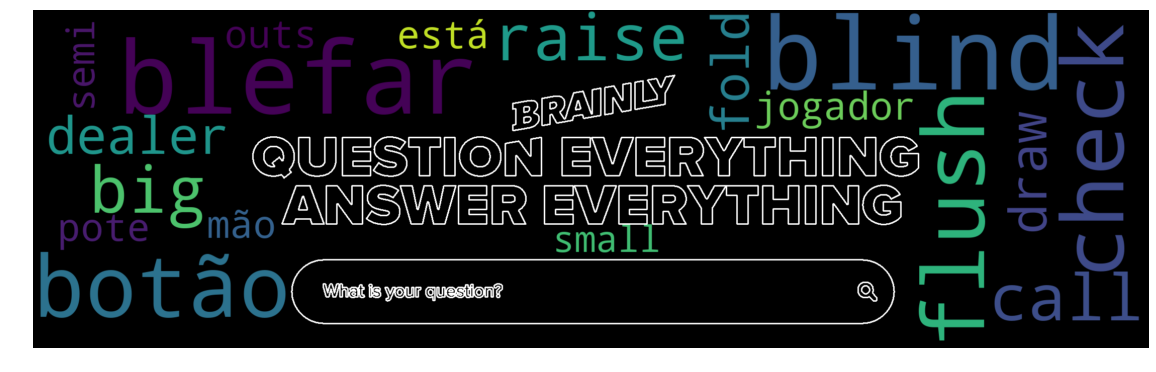

In [30]:
from os import path
import numpy as np
from PIL import Image

mask = np.array(Image.open(path.join("c.png")))

wc = WordCloud(mask=mask, background_color='black',contour_width=2, contour_color='white')

# Generate a wordcloud
wc.generate(string_lex)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

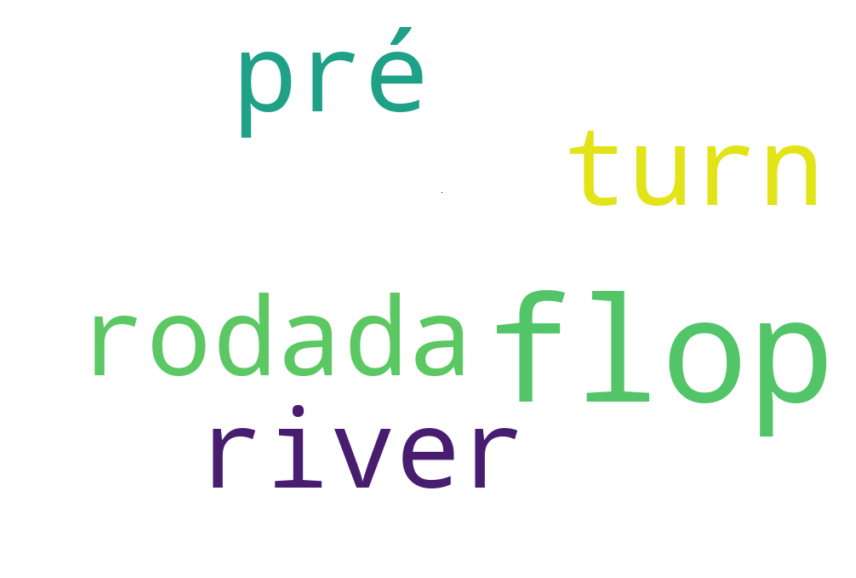

In [31]:
mask = np.array(Image.open(path.join("kek.jpg")))

wc_c = WordCloud(mask=mask, background_color='white',contour_width=1, contour_color='black')

# Generate a wordcloud
wc_c.generate(string_cen)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc_c, interpolation='bilinear')
plt.axis("off")
plt.show()